# Análisis Humedad Antecedente

Este código pretende realizar los cálculos de análisis de los eventos ubicados entre el 2013 y el 2016 en la estación de **Aula Ambiental**, se pretende establecer lo siguiente:

1. Relación entre caudal y lluvia para los diferentes eventos.
2. Identificación de eventos de hidrógrafa dentro del periodo seleccionado.
3. Identificar mediante correlaciones cual es la memoria de la cuenca asociada a los eventos evaluados.
4. Calibrar el modelo hidrológico para los eventos seleccionados.
5. Analizar la afectación que presenta la memoria de la cuenca sobre los eventos seleccionados.

In [2]:
%matplotlib inline 
import pandas as pd 
import pylab as pl 
import numpy as np 
import datetime 
from wmf import wmf

In [3]:
def FindMax(Q,fechas,umbral,horasAtras=12,BusquedaAdelante=36):
    pos=np.where(Q>umbral)[0]
    grupos=[];g=[];Qmax=[]
    #Encuentra el maximo de cada grupo
    for pant,pnext in zip(pos[:-1],pos[1:]):        
        if pant+1>=pnext and pant+BusquedaAdelante>=pnext:
            g.append(pant)
        else:
            if len(g)>0:
                PosMaxGrupo=np.argmax(Q[g])
                grupos.append(g[PosMaxGrupo])
                Qmax.append(np.max(Q[g]))
            g=[]
    #Pule el maximo por si hay noData
    for c,g in enumerate(grupos):
        if Q.mask[g-1]:
            grupos.pop(c)
    #Obtiene las fechas 12 horas atras 
    if type(fechas)==list:
        fechas=np.array(fechas)
    FechasAtras=fechas[grupos]-datetime.timedelta(hours=horasAtras)
    fechas=list(fechas)     
    posAtras=[fechas.index(i) for i in FechasAtras]
    return grupos,np.array(Qmax)

## 0. Union de la lluvia en una sola serie

In [16]:
ruta = '/media/nicolas/Home/nicolas/01_SIATA/bin_rain/Aula30m/CampoAula_u0.005_'

In [25]:
dates = pd.date_range('2011-12-31','2016-12-31',freq='5min')
Rain = pd.Series(np.zeros(dates.shape[0]), dates)

In [37]:
for i in range(2012, 2017):
    rutaC = ruta+str(i)+'_300s.hdr'
    RainT = wmf.read_mean_rain(rutaC)
    Rain[RainT.index] = RainT

In [39]:
Rain.to_msgpack('/media/nicolas/Home/Jupyter/Nicolas/Trabajo/02_series/Rain-Aula-u0.005-300s-20111231-20161231.msg')

## 1. Análisis Relación Caudal Vs Lluvia por Eventos 

Se realiza la lectura de las series obtenidas de caudal en la estación de Aula abiental y se lee la lluvia promedio sobre la cuenca del Valle de Aburrá para los eventos.

In [40]:
Q = pd.read_msgpack('/media/nicolas/Home/Jupyter/Nicolas/Trabajo/02_series/QAula-20121201-20161231.msg')
Rain = pd.read_msgpack('/media/nicolas/Home/Jupyter/Nicolas/Trabajo/02_series/Rain-Aula-u0.005-300s-20111231-20161231.msg')

Se encuentran los eventos en donde se alcanza un caudal igual o mayor a **50** 

In [41]:
#Busqueda de maximos 
Qma = np.ma.array(Q.values, mask=Q.values > 1500)
G, Qmax = FindMax(Qma, Q.index.to_pydatetime(), 50, BusquedaAdelante=36)
#Maximos establecidos como series de pandas
Gs = pd.Series(Qma[G], index=Q.index[G])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


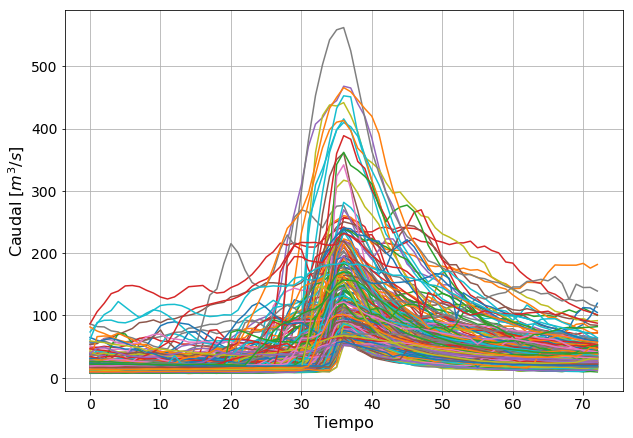

In [105]:
tm = pd.Timedelta('3 hours')
tm2 = pd.Timedelta('500 hours')
tm3 = pd.Timedelta('240 hours')
c = 0
fig = pl.figure(figsize=(10,7))
ax = fig.add_subplot(111)
Matriz = []
Pos = []
for p,i in enumerate(Gs.index):
    if Q[i - tm: i + tm].values.argmax() == 36 and Rain[i-tm:i].sum() > 1.0 and Rain[i-tm2:i].sum() < 500 and Rain[i-tm3:i].sum() < 200 and Q[i-tm:i+tm].max()<600:
        ax.plot(Q[i - tm: i + tm].values)
        Matriz.append(Q[i - tm: i + tm].values)
        c+=1
        Pos.append(p)
pl.grid()
pl.xlabel('Tiempo', size = 16)
pl.ylabel('Caudal [$m^3/s$]', size = 16)
ax.tick_params(labelsize = 14)
GsCut = Gs[Pos]

**Figura**: Eventos Seleccionados, donde se cumple que: El caudal es mayor a 50m3 y la lluvia acumulada es mayor a 1mm.

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


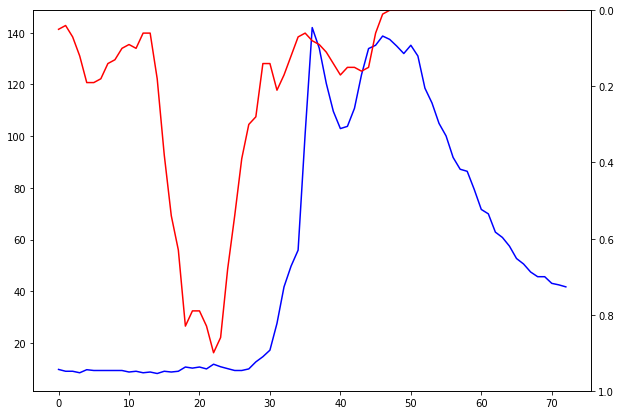

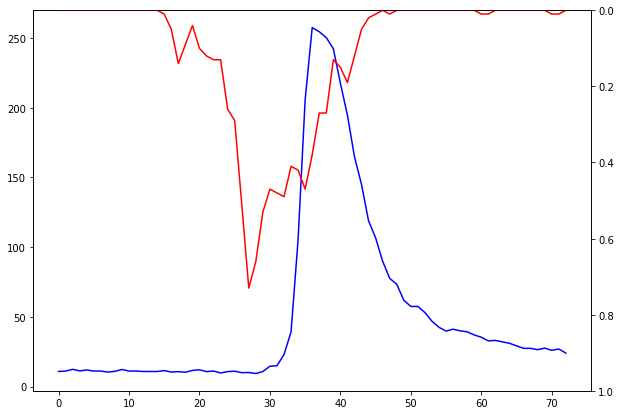

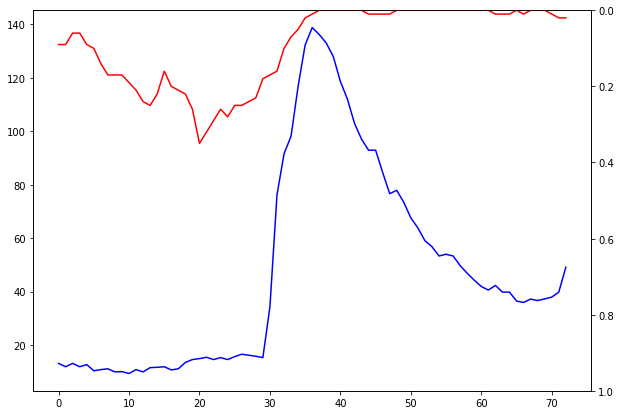

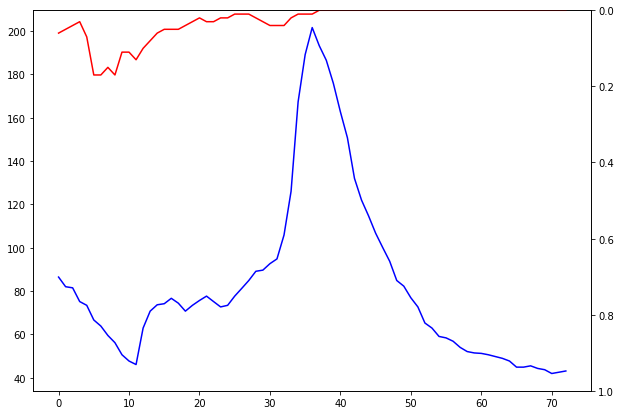

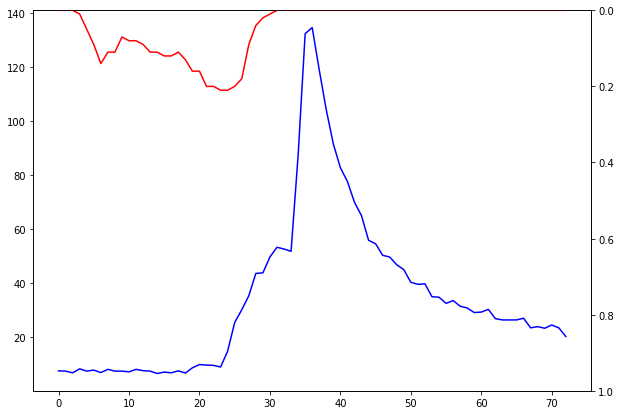

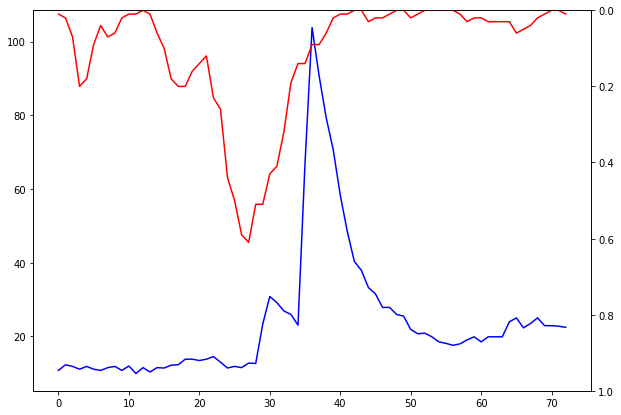

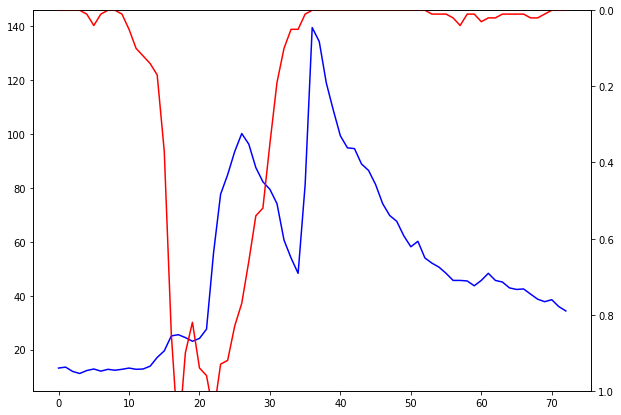

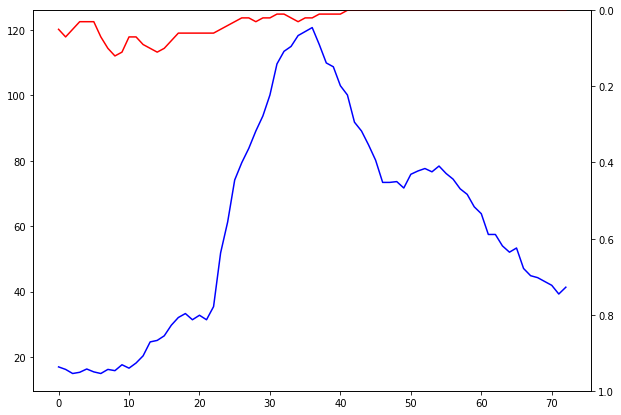

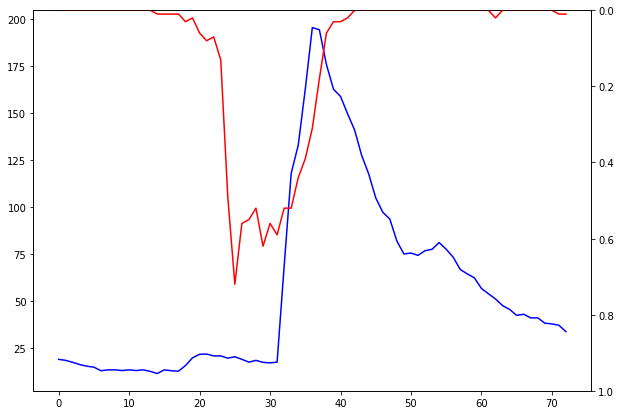

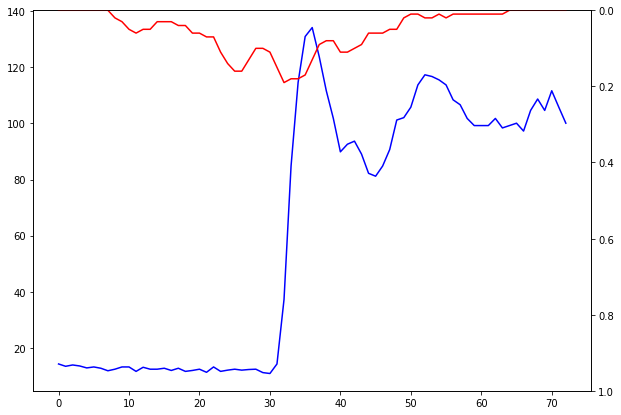

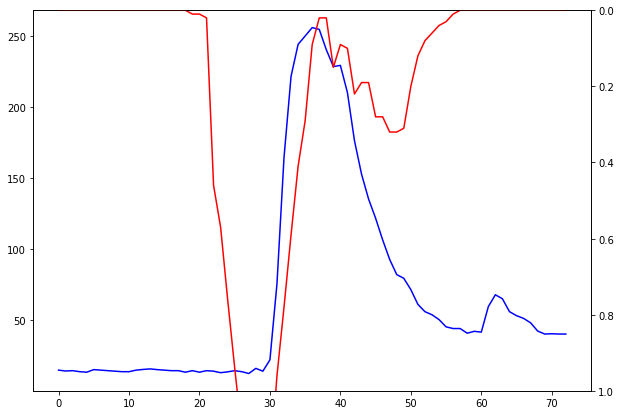

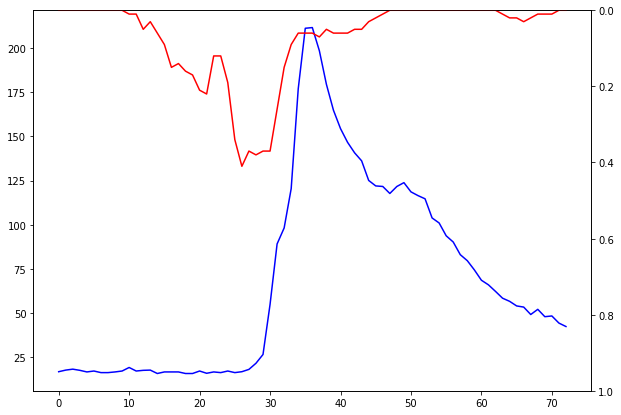

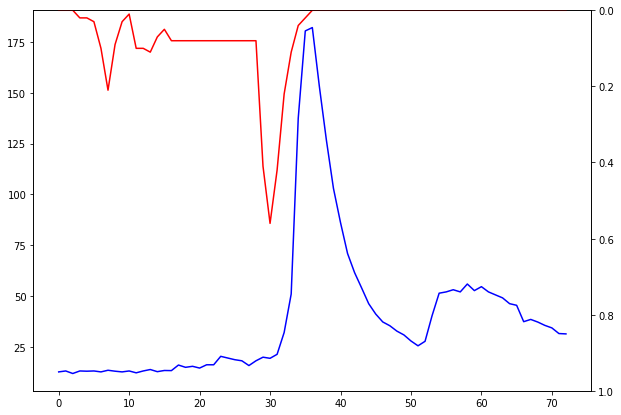

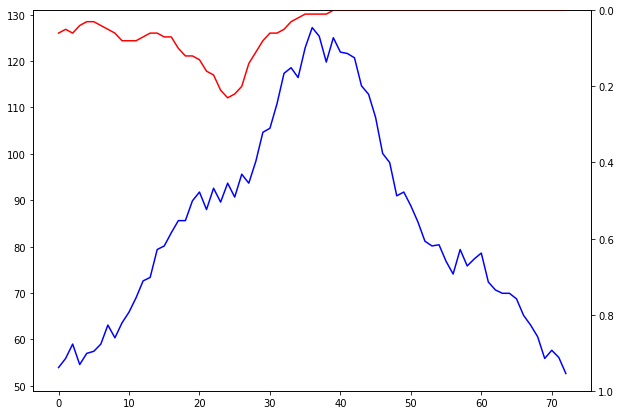

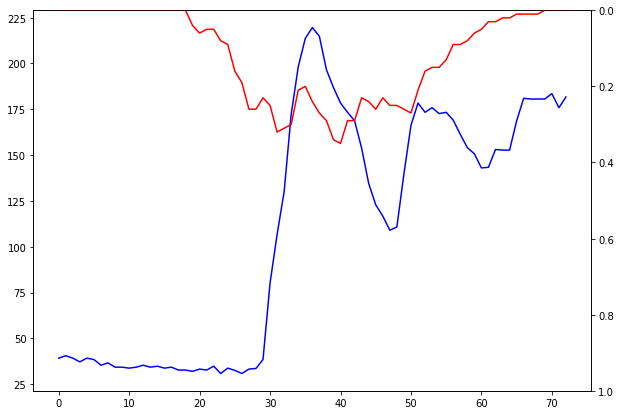

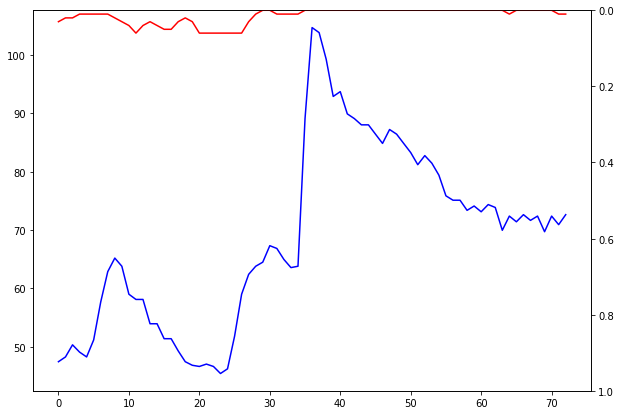

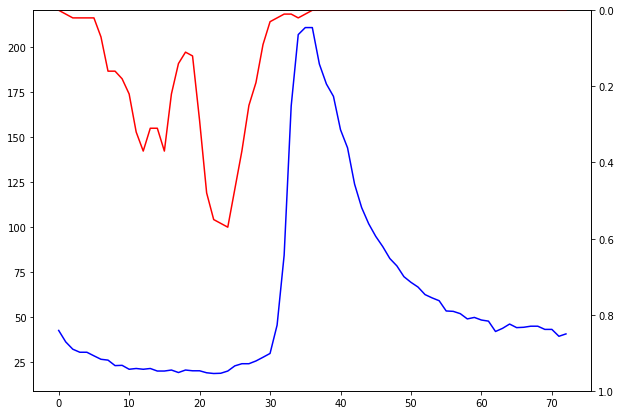

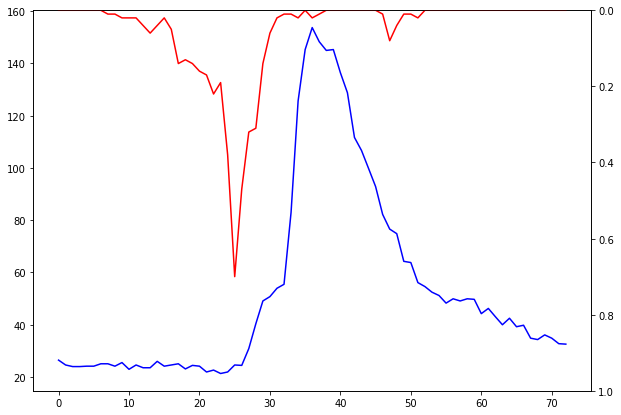

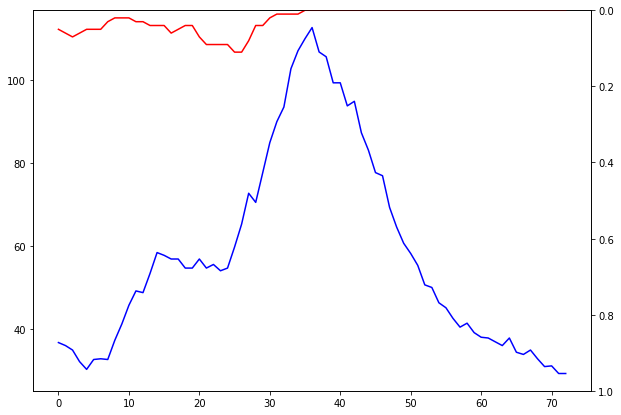

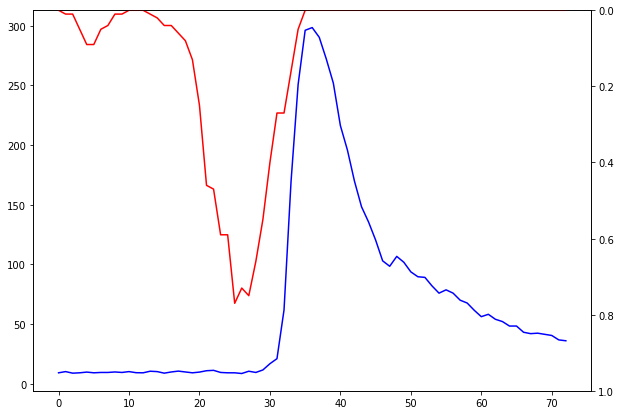

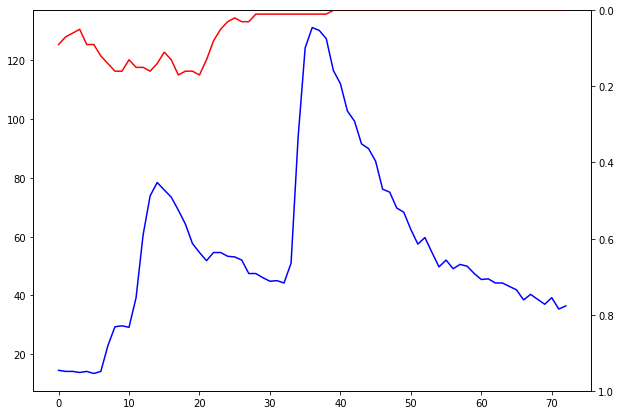

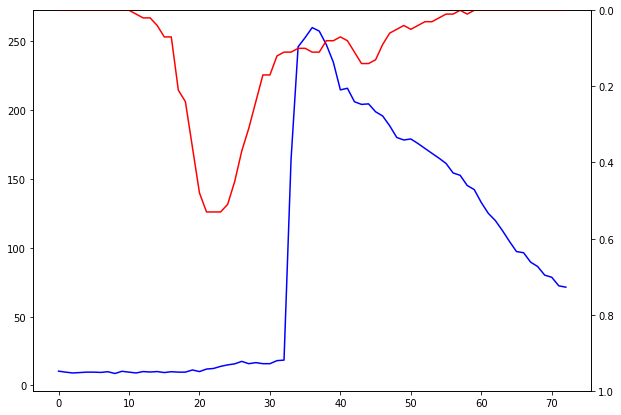

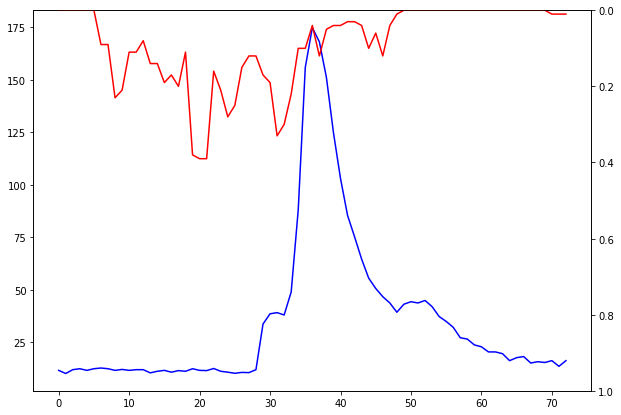

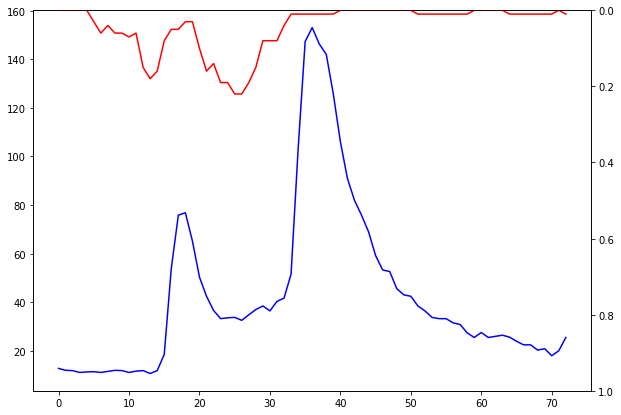

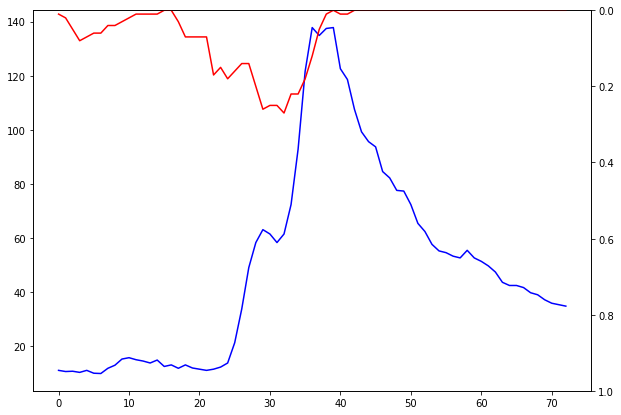

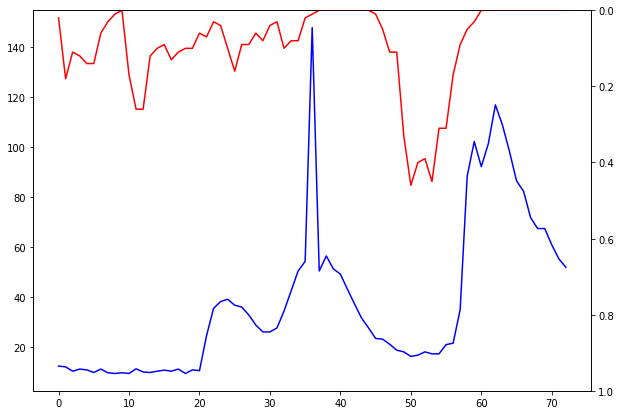

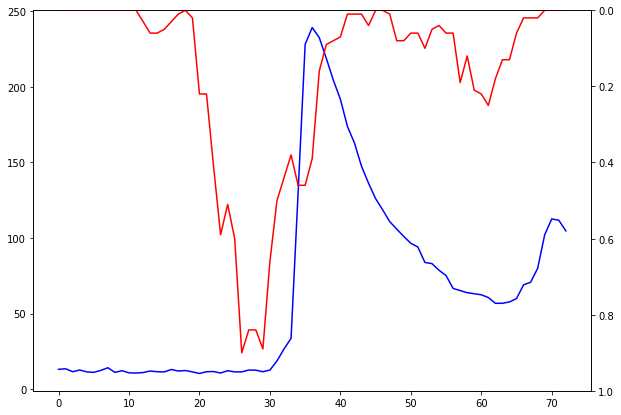

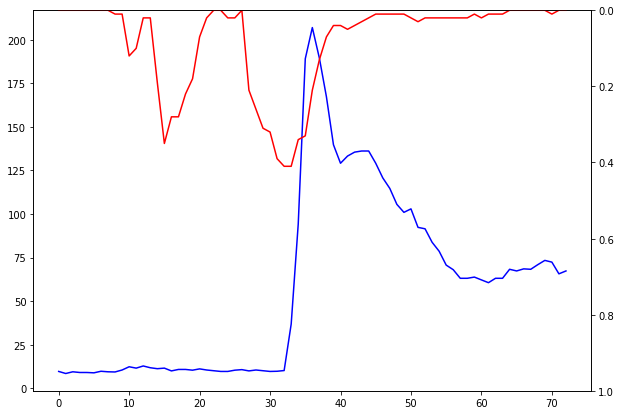

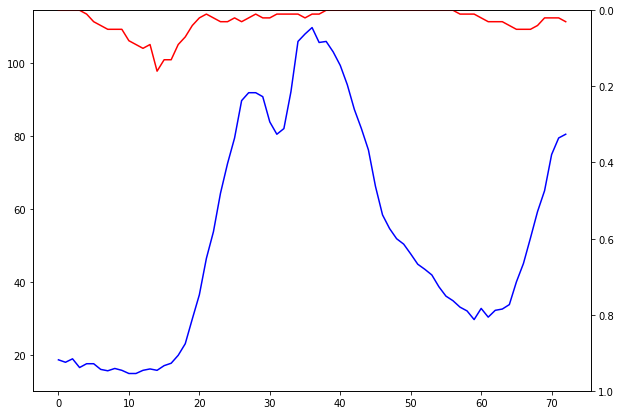

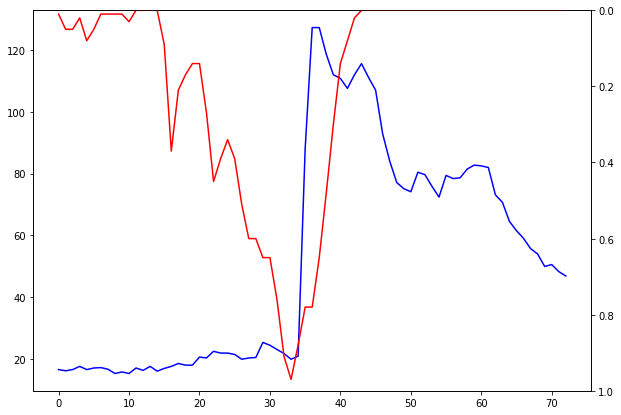

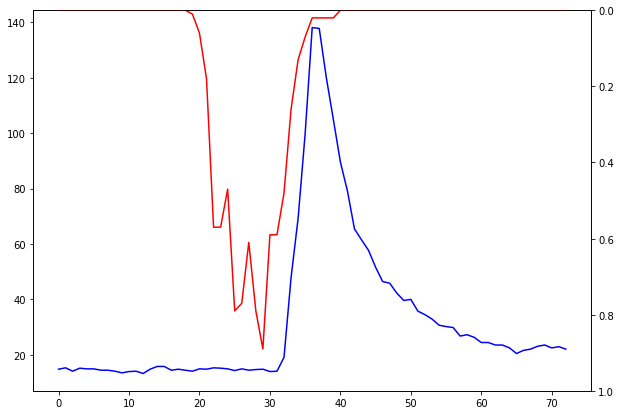

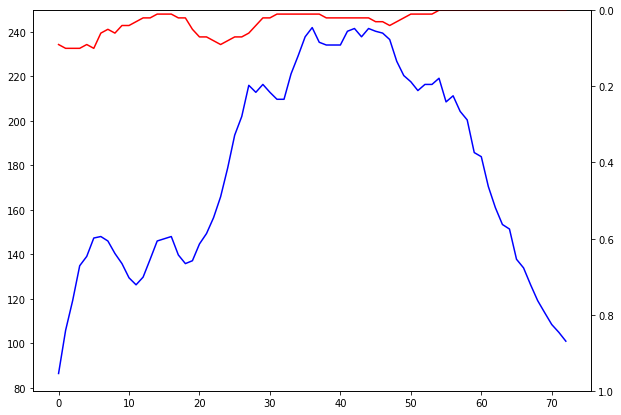

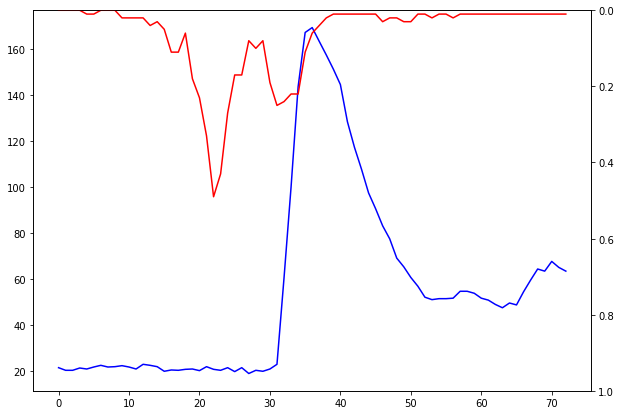

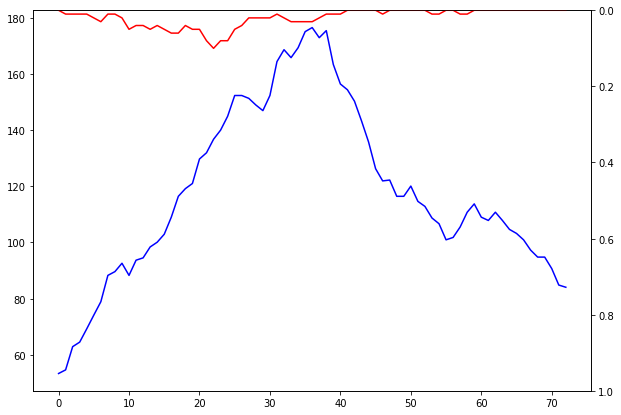

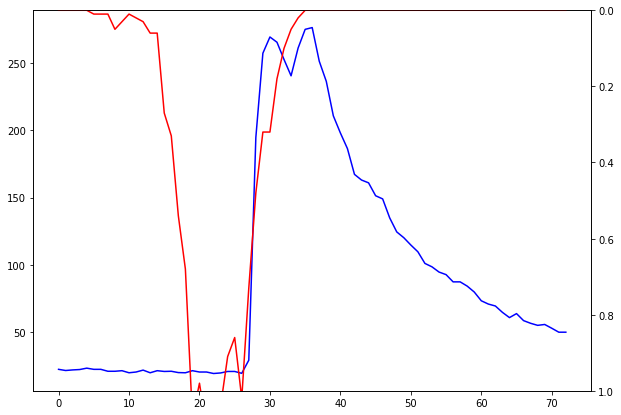

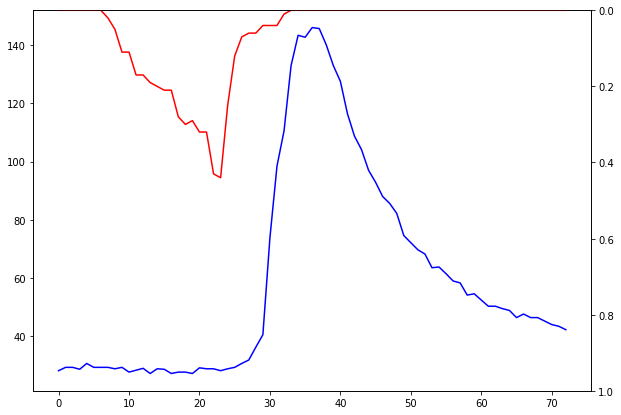

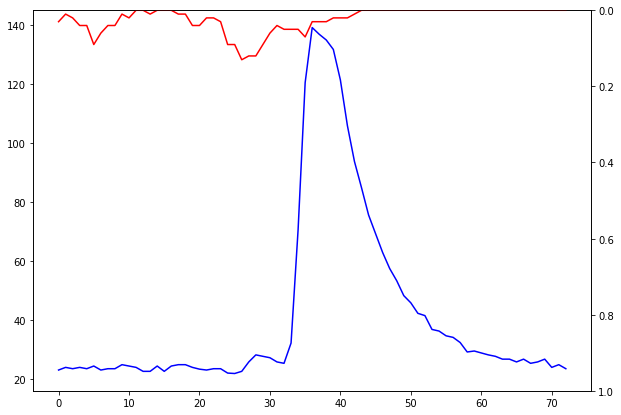

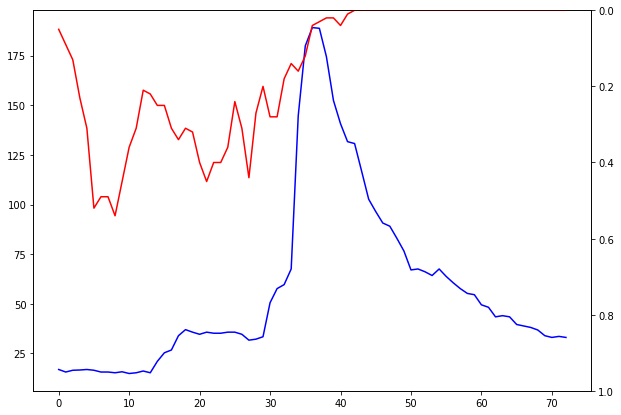

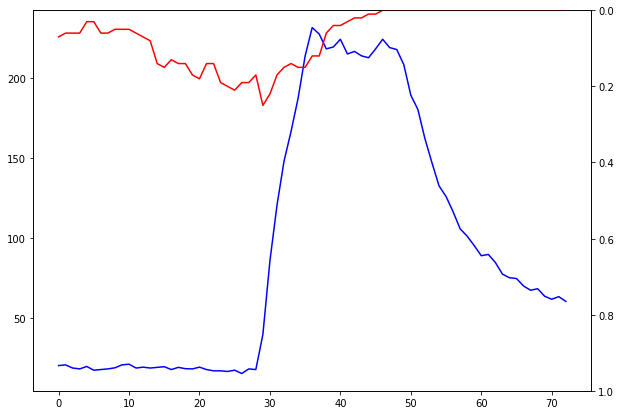

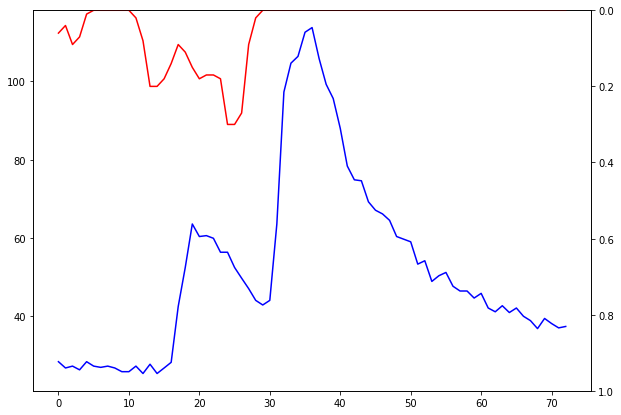

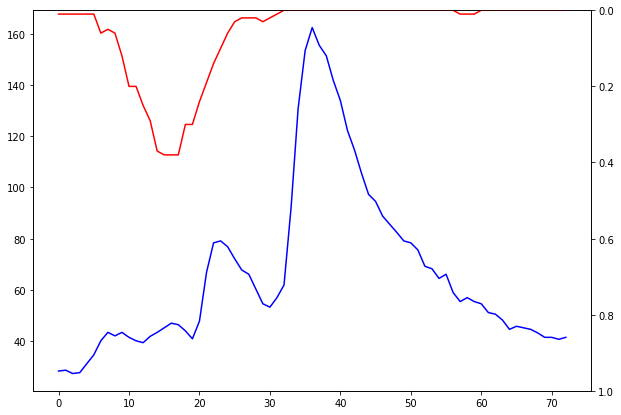

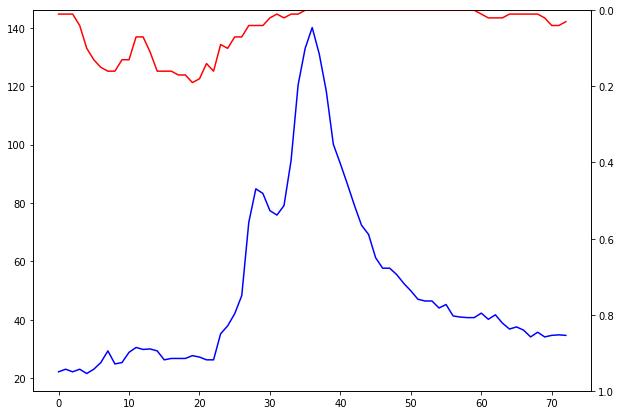

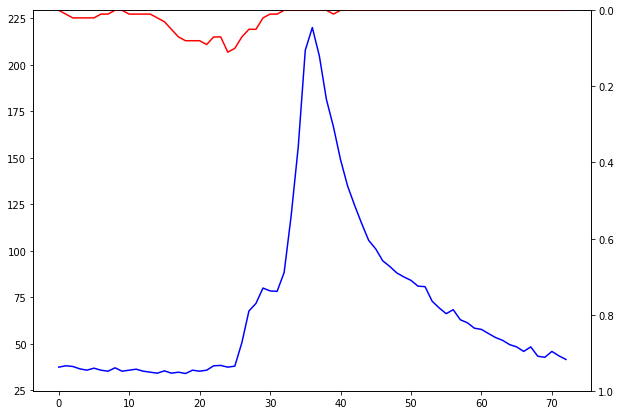

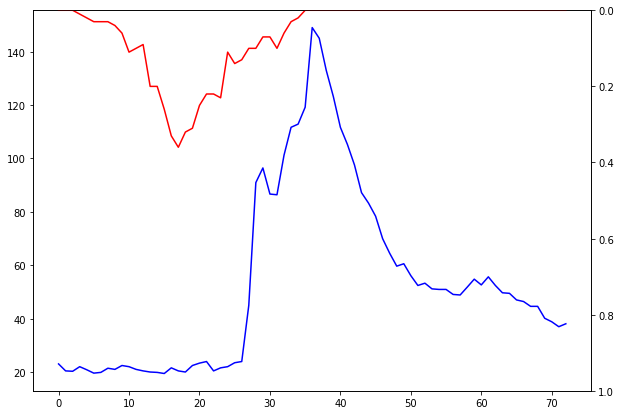

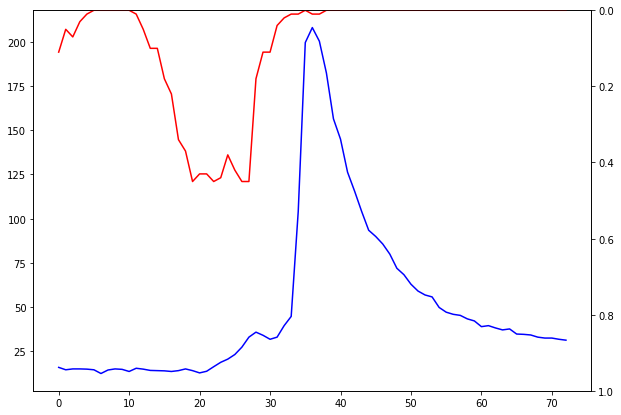

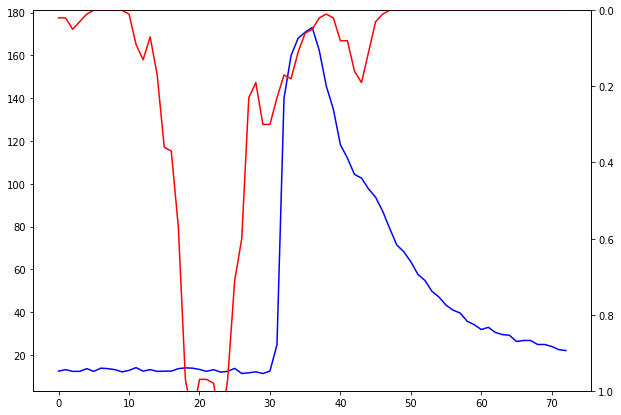

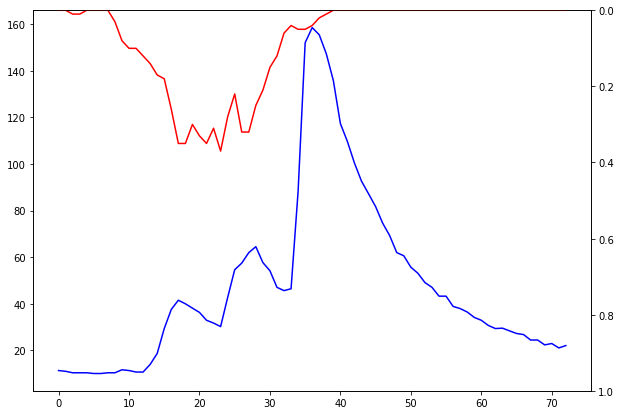

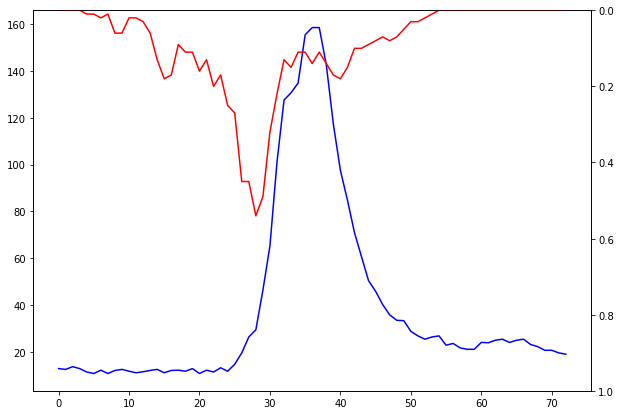

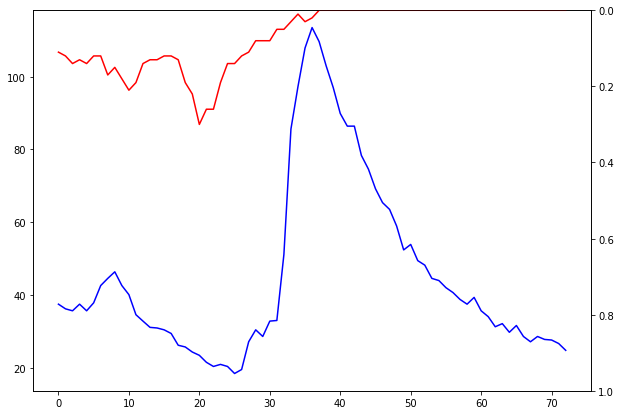

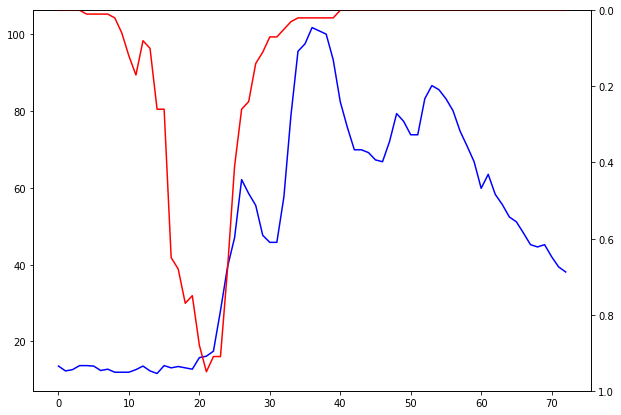

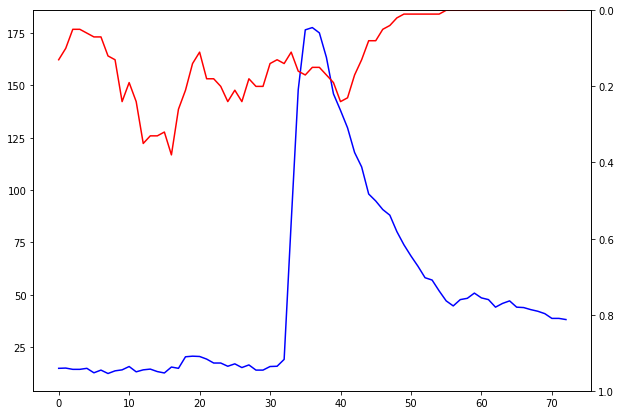

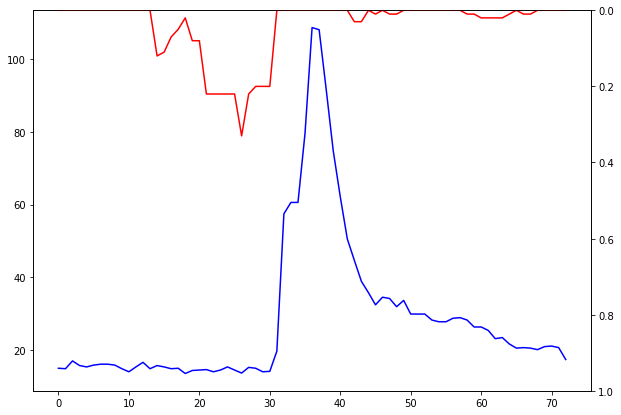

In [47]:
for i in GsCut.index[:100]:
    if Q[i-tm:i+tm].max()>100 and Q[i-tm:i+tm].max()<300:
        fig = pl.figure(figsize=(10,7))
        ax = fig.add_subplot(111)
        #ax2AX=pl.gca()
        ax2 = ax.twinx()
        ax2.set_ylim(ax2.get_ylim()[::-1])
        ax.plot(Q[i-tm:i+tm].values, 'b')
        ax2.plot(Rain[i-tm:i+tm].values, 'r')

**Figuras**: Figuras de las relaciones entre el caudal observado en aula ambiental y la lluvia que ocurre en la cuenca, estas son las figuras resultado para los 149 eventos seleccionados.

Ahora se van a sacar datos sobre la lluvia y el caudal en cada uno de los eventos.

In [169]:
tm = pd.Timedelta('3 hours')
tm2 = pd.Timedelta('415 hours')

DQ = {'max':[],'vol':[]}
DR = {'max':[],'tot':[],'ante':[], 'p80':[], 'p90':[], 'p95':[]}

for i in GsCut.index:
    #Propiedades del cadual
    DQ['max'].append(Q[i-tm:i+tm].max())
    #Propiedades de la lluvia 
    DR['max'].append(Rain[i-tm:i+tm].max())
    DR['tot'].append(Rain[i-tm:i+tm].sum())
    DR['ante'].append(Rain[i-tm2:i+tm].sum())
    DR['p80'].append(np.percentile(Rain[i-tm:i+tm], 80))
    DR['p90'].append(np.percentile(Rain[i-tm:i+tm], 90))
    DR['p95'].append(np.percentile(Rain[i-tm:i+tm], 95))

In [170]:
a = np.array(DR['ante'])

In [171]:
a[a>150] = 100

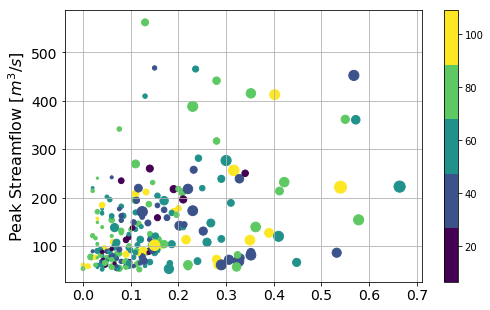

In [191]:
fig = pl.figure(figsize=(8,5))
ax = fig.add_subplot(111)
pl.scatter(DR['p80'], DQ['max'], c = a,s = np.array(DR['p95'])*100, cmap=pl.get_cmap('viridis',5))
cbar = pl.colorbar()
ax.grid(True)
ax.tick_params(labelsize = 14)
ax.set_ylabel('Peak Streamflow [$m^3/s$]', size = 16)

### 1.1. Relación del Caudal Máximo con el acumulado atrás

Se comparan las siguientes características de las hidrógrafas:
- Caudal máximo.
- Intensidad máxima de la tormenta 
- Acumulado de la tormenta.
- Acumulado de lluvia días previos a la tormenta 

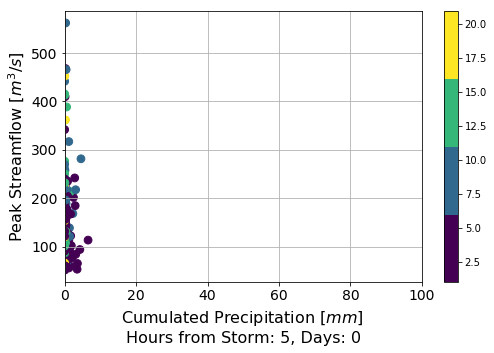

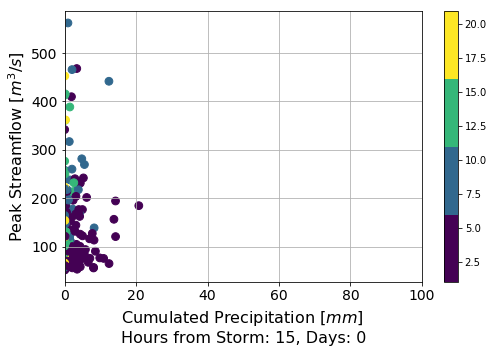

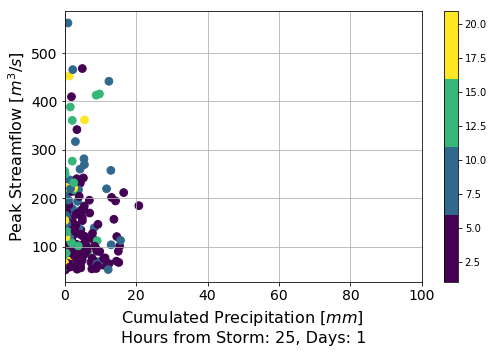

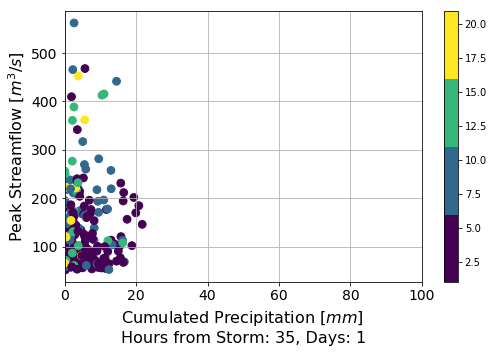

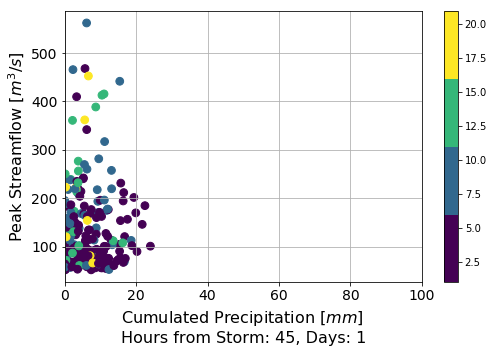

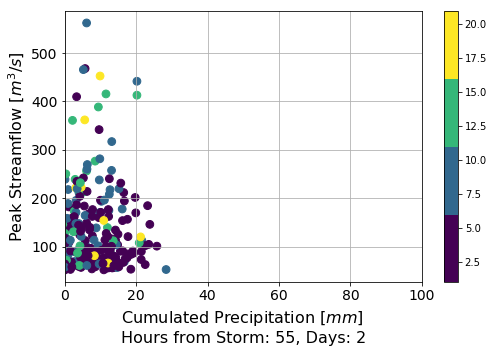

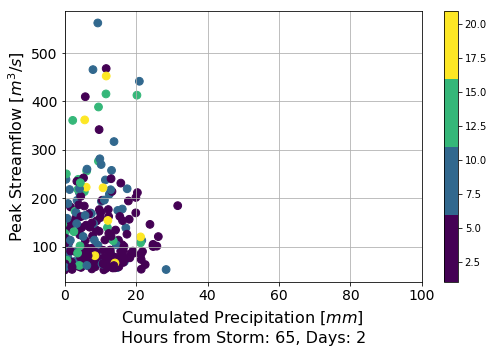

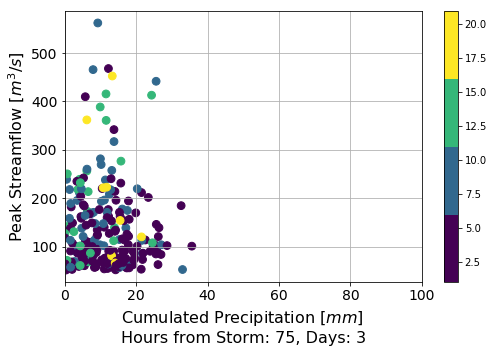

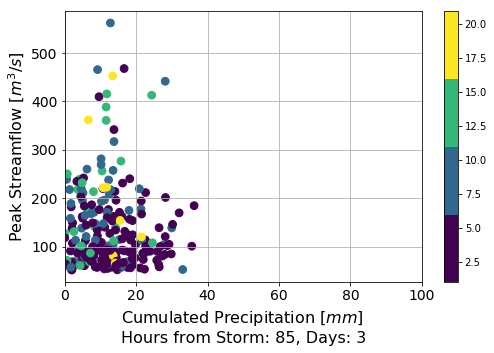

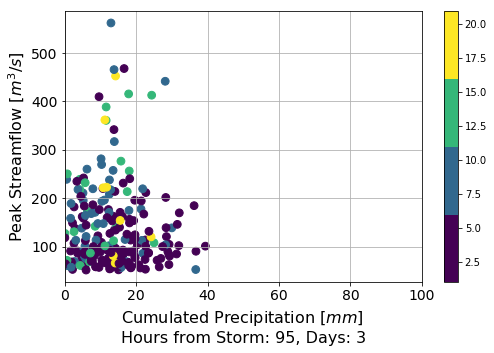

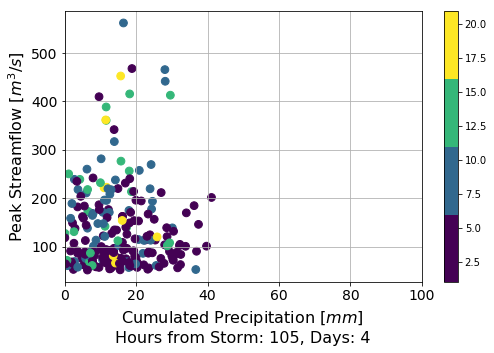

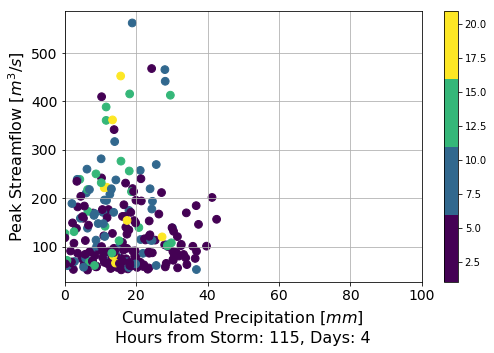

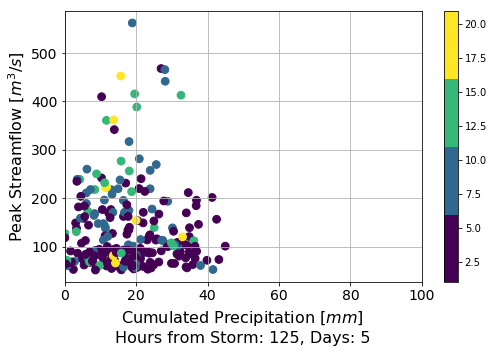

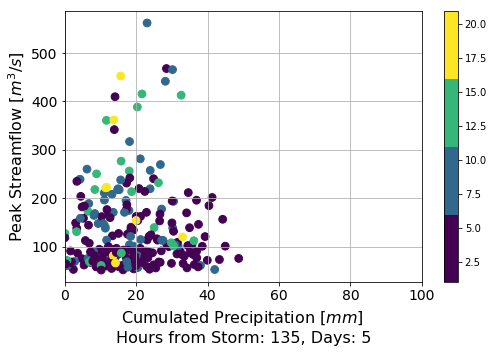

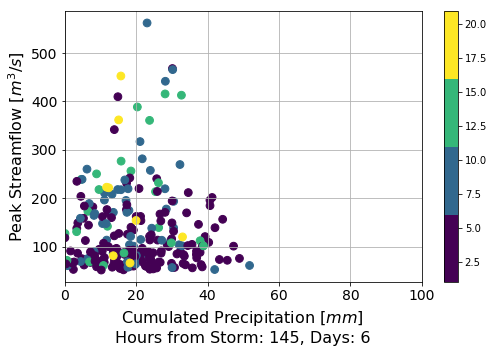

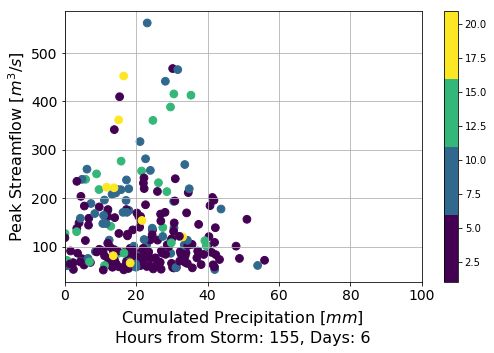

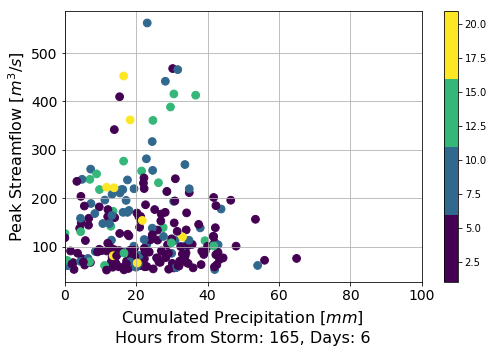

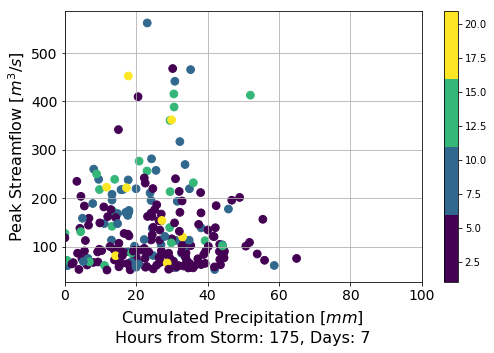

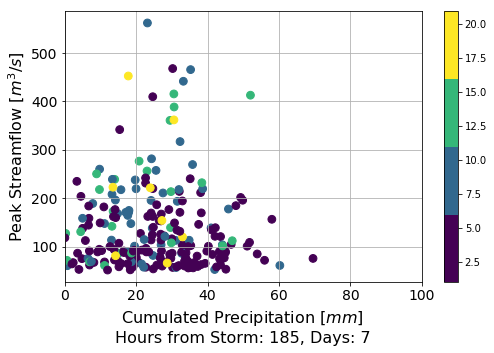

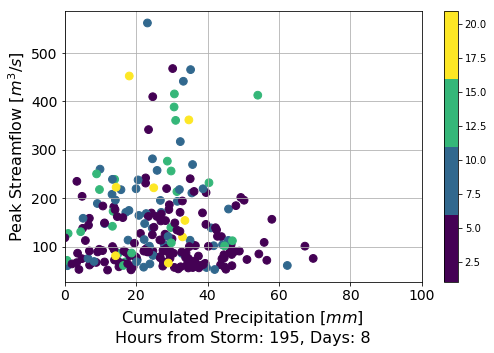

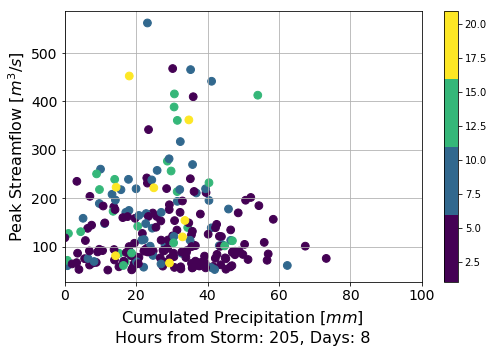

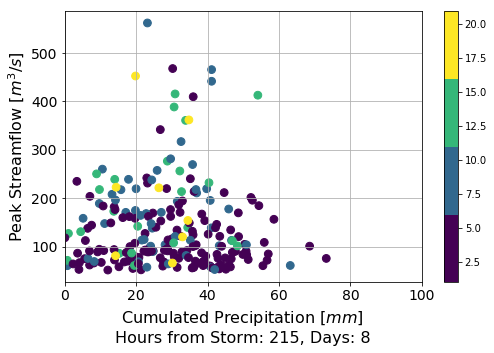

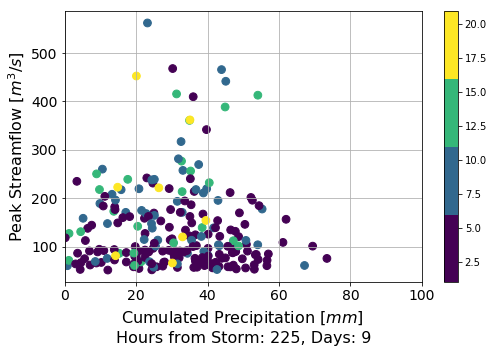

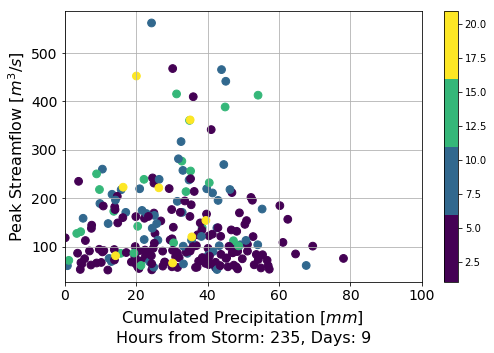

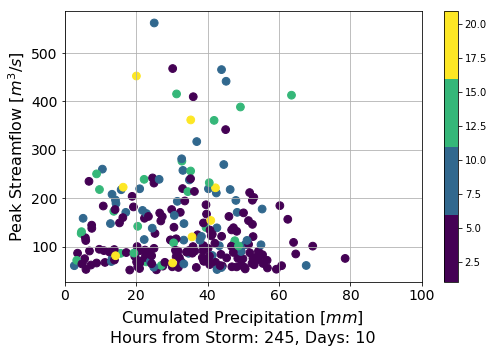

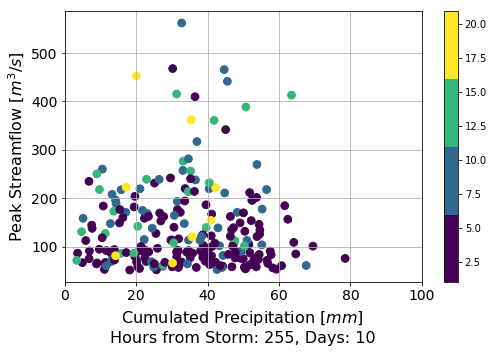

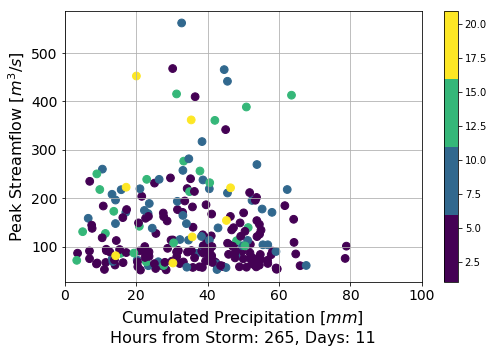

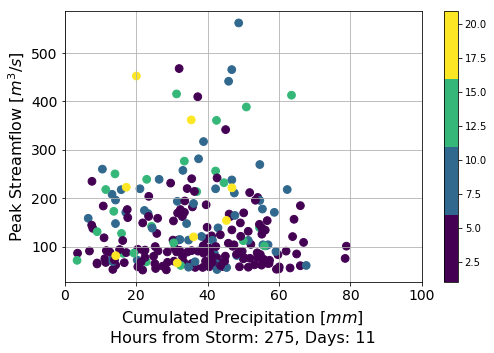

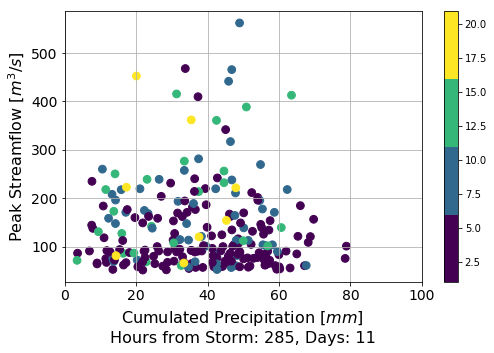

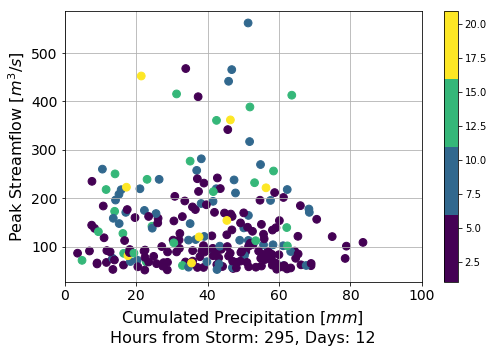

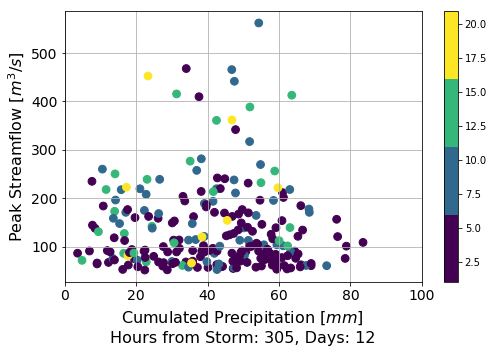

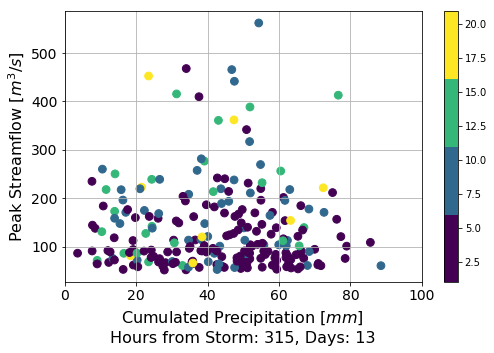

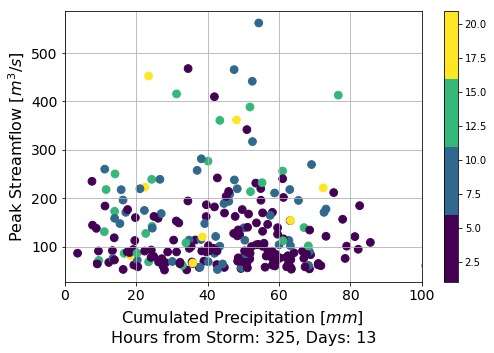

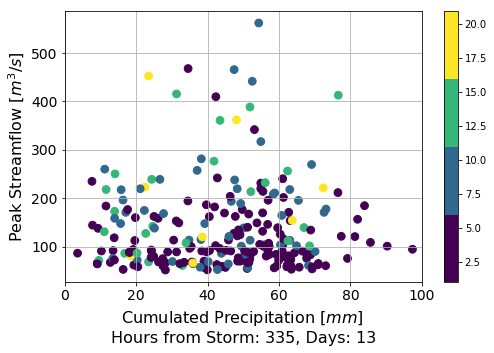

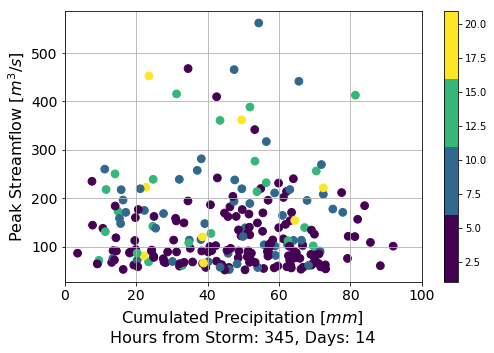

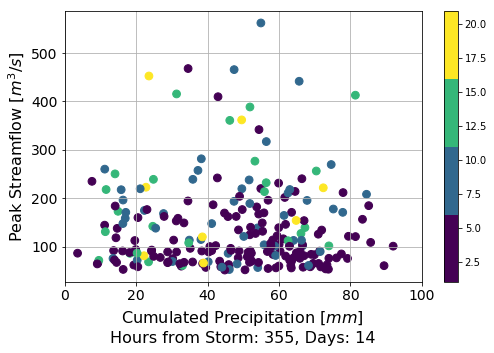

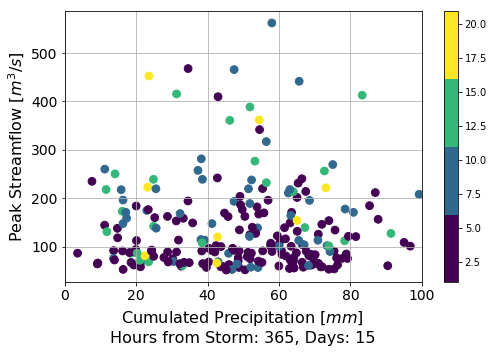

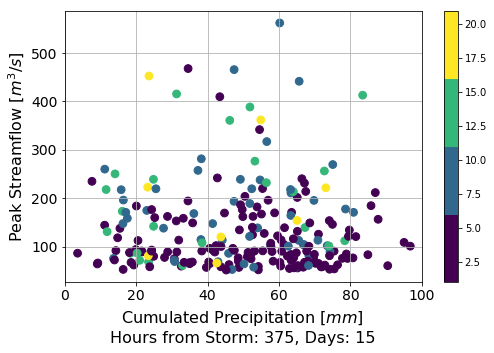

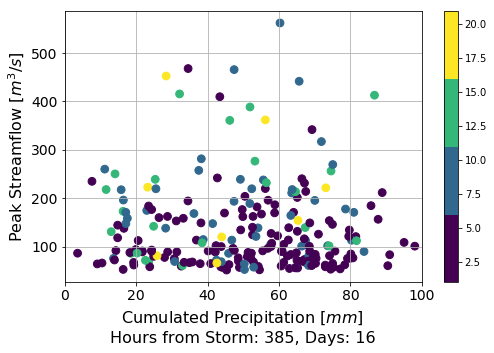

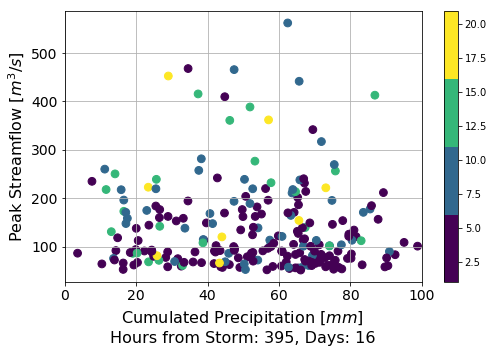

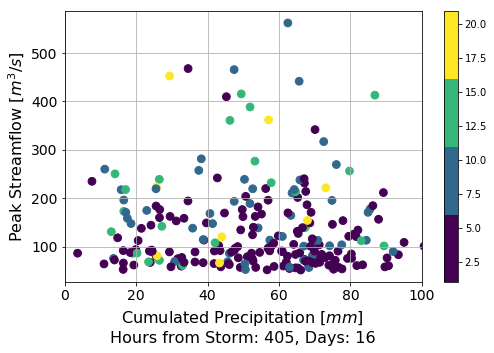

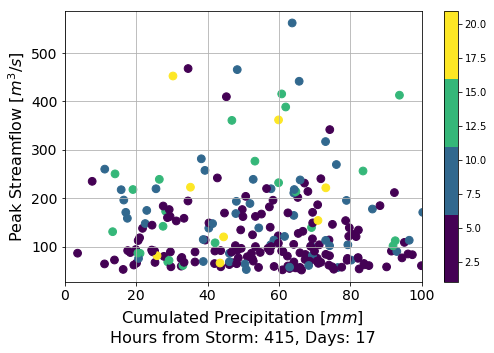

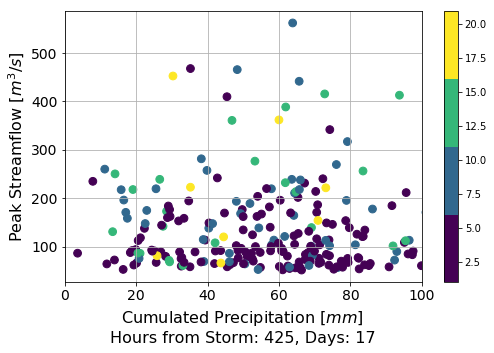

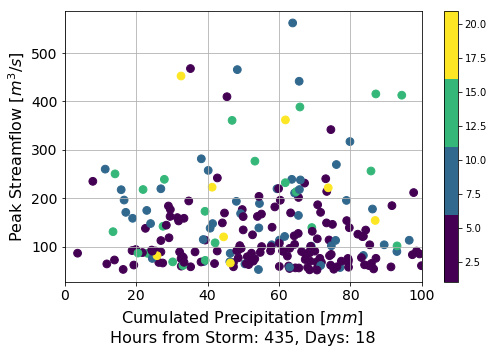

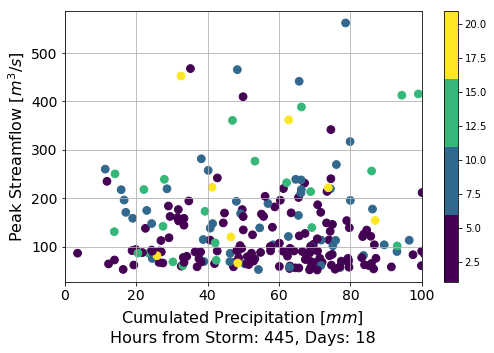

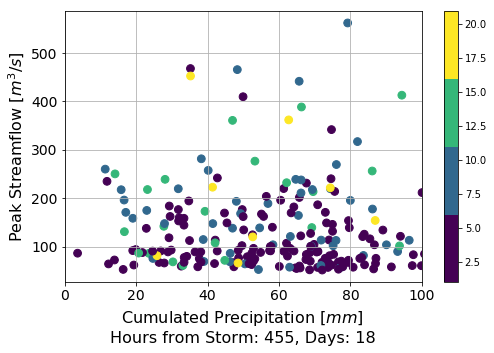

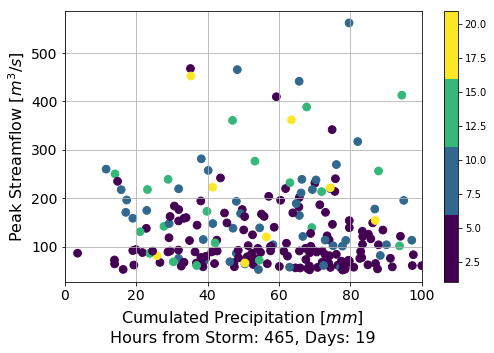

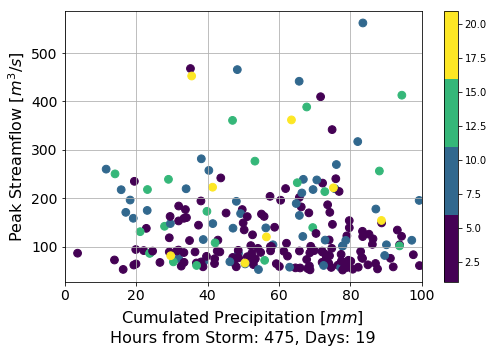

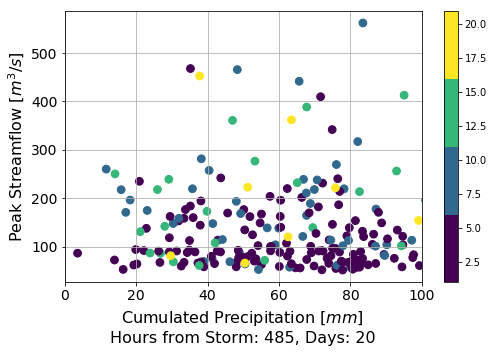

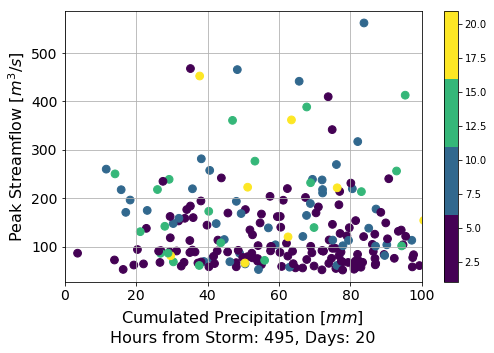

In [122]:
Anteriores = []
for j in range(5, 500, 10):
    Anterior = []
    for i in GsCut.index:
        tm2 = pd.Timedelta(str(j)+' hours')
        Anterior.append(Rain[i-tm2:i-tm].sum())
    Anteriores.append(Anterior)
    #Figura para cada caso
    fig = pl.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    pl.scatter(Anterior,DQ['max'], c = DR['tot'],s = 60, cmap=pl.get_cmap('viridis',4))
    cbar = pl.colorbar()
    ax.grid(True)
    ax.set_xlim(0,100)
    ax.tick_params(labelsize = 14)
    dias = j/24.0
    texto = 'Hours from Storm: '+str(j)+', Days: %d' % dias
    ax.set_xlabel('Cumulated Precipitation [$mm$] \n'+texto, size =16)
    ax.set_ylabel('Peak Streamflow [$m^3/s$]', size = 16)

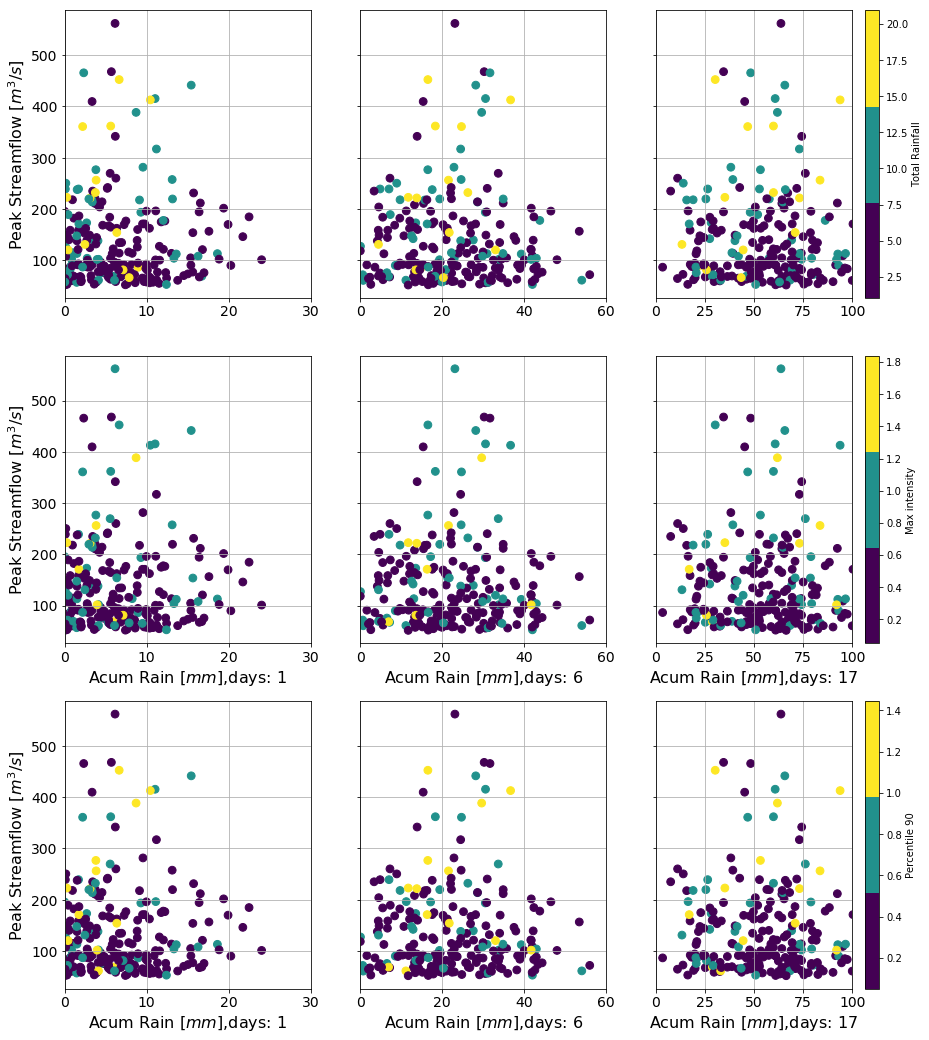

In [148]:
horas = [45, 165, 415]
xlim = [30, 60, 100]
fig = pl.figure(figsize=(15,18))
for c,j in enumerate(horas):
    Anterior = []
    for i in GsCut.index:
        tm2 = pd.Timedelta(str(j)+' hours')
        Anterior.append(Rain[i-tm2:i-tm].sum())
    
    #Figura Lluvia acumulada
    ax = fig.add_subplot(3,3,c+1)
    pl.scatter(Anterior,DQ['max'], c = DR['tot'],s = 60, cmap=pl.get_cmap('viridis',3))
    if c == 2:
        cbar = pl.colorbar()
        cbar.set_label('Total Rainfall')
    ax.grid(True)
    ax.set_xlim(0,xlim[c])
    ax.tick_params(labelsize = 14)
    if c<>0: 
        ax.set_yticklabels([])
    dias = j/24.0
    if c == 0:
        ax.set_ylabel('Peak Streamflow [$m^3/s$]', size = 16)
    
    #Figura Intensidad maxima
    ax = fig.add_subplot(3,3,c+4)
    pl.scatter(Anterior,DQ['max'], c = DR['max'],s = 60, cmap=pl.get_cmap('viridis',3))
    if c == 2:
        cbar = pl.colorbar()
        cbar.set_label('Max intensity')
    if c<>0: 
        ax.set_yticklabels([])
    ax.grid(True)
    ax.set_xlim(0,xlim[c])
    ax.tick_params(labelsize = 14)
    dias = j/24.0
    texto = 'Acum Rain [$mm$],days: %d' % dias
    ax.set_xlabel(texto, size =16)
    if c == 0:
        ax.set_ylabel('Peak Streamflow [$m^3/s$]', size = 16)
        
    #Figura P90
    ax = fig.add_subplot(3,3,c+7)
    pl.scatter(Anterior,DQ['max'], c = DR['p95'],s = 60, cmap=pl.get_cmap('viridis',3))
    if c == 2:
        cbar = pl.colorbar()
        cbar.set_label('Percentile 90')
    if c<>0: 
        ax.set_yticklabels([])
    ax.grid(True)
    ax.set_xlim(0,xlim[c])
    ax.tick_params(labelsize = 14)
    dias = j/24.0
    texto = 'Acum Rain [$mm$],days: %d' % dias
    ax.set_xlabel(texto, size =16)
    if c == 0:
        ax.set_ylabel('Peak Streamflow [$m^3/s$]', size = 16)
    

In [ ]:
1.6